In [5]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd

src_path = Path(
    "/Users/pszyc/Library/CloudStorage/GoogleDrive-przemek.7678@gmail.com/My Drive/Studia/Ogniska/"
)

data_files = list(src_path.rglob("00*"))

data_files = [path for path in data_files if (path / "foci_mask.npy").exists()]
print(len(data_files))

679


In [49]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.ndimage import label

rows_ch1 = []
rows_ch2 = []
rows_overlap = []

def append_components(binary_mask, image_info, out_rows):
    cc_mask, n_cc = label(binary_mask, structure=np.ones((3, 3, 3), dtype=np.uint8))
    if n_cc == 0:
        return
    sizes = np.bincount(cc_mask.ravel())[1:]  # skip background
    for comp_label, comp_size in enumerate(sizes, start=1):
        out_rows.append({
            "image_info": image_info,
            "foci_label": int(comp_label),
            "foci_size": int(comp_size),
        })

for data_selected in tqdm(data_files):
    image_info = "/".join(str(data_selected).split("/")[-3:])
    foci_mask_path = data_selected / "foci_mask.npy"

    # expected shape: (2, Z, Y, X)
    mask = np.load(foci_mask_path)
    mask = mask[:, 11:30, :, :]

    ch1_mask = mask[0] > 0
    ch2_mask = mask[1] > 0
    overlap_mask = ch1_mask & ch2_mask

    append_components(ch1_mask, image_info, rows_ch1)
    append_components(ch2_mask, image_info, rows_ch2)
    append_components(overlap_mask, image_info, rows_overlap)

def rows_to_df(rows):
    if len(rows) == 0:
        return pd.DataFrame(columns=["image_info", "foci_label", "foci_size"])
    return (
        pd.DataFrame(rows)
        .sort_values(["image_info", "foci_label"])
        .reset_index(drop=True)
    )

ch1_df = rows_to_df(rows_ch1)
ch2_df = rows_to_df(rows_ch2)
overlap_df = rows_to_df(rows_overlap)

# keep backward compatibility with later cells

print(f"ch1_df: {len(ch1_df)} rows")
print(f"ch2_df: {len(ch2_df)} rows")
print(f"overlap_df: {len(overlap_df)} rows")

ch1_df.head()

100%|██████████| 679/679 [10:04<00:00,  1.12it/s]


ch1_df: 486234 rows
ch2_df: 648874 rows
overlap_df: 490468 rows


,image_info,foci_label,foci_size
0,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",1,165
1,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",2,18
2,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",3,79
3,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",4,123
4,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",5,56


In [50]:
ch1_df.to_csv("foci_ch1.csv", index=False)
ch2_df.to_csv("foci_ch2.csv", index=False)
overlap_df.to_csv("foci_overlap.csv", index=False)

print("Saved: foci_ch1.csv, foci_ch2.csv, foci_overlap.csv")

Saved: foci_ch1.csv, foci_ch2.csv, foci_overlap.csv


In [61]:
ch1_df = pd.read_csv("foci_ch1.csv")
ch2_df = pd.read_csv("foci_ch2.csv")
overlap_df = pd.read_csv("foci_overlap.csv")

# keep backward compatibility with later cells
print(f"Loaded ch1_df: {len(ch1_df)} rows")
print(f"Loaded ch2_df: {len(ch2_df)} rows")
print(f"Loaded overlap_df: {len(overlap_df)} rows")

Loaded ch1_df: 486234 rows
Loaded ch2_df: 648874 rows
Loaded overlap_df: 490468 rows


In [62]:
z_scale, x_scale, y_scale = 50 / 48, 1040 / 505, 1392 / 681

def add_volume_features(df, size_col="foci_size"):
    df = df.copy()
    df["vol"] = df[size_col] * 0.065 * 0.065 * 0.3 * z_scale * x_scale * y_scale
    df["x"] = np.cbrt(df["vol"])
    return df

ch1_df = add_volume_features(ch1_df)
ch2_df = add_volume_features(ch2_df)
overlap_df = add_volume_features(overlap_df)

# keep backward compatibility with downstream cells
print("Processed: ch1_df, ch2_df, overlap_df")

Processed: ch1_df, ch2_df, overlap_df


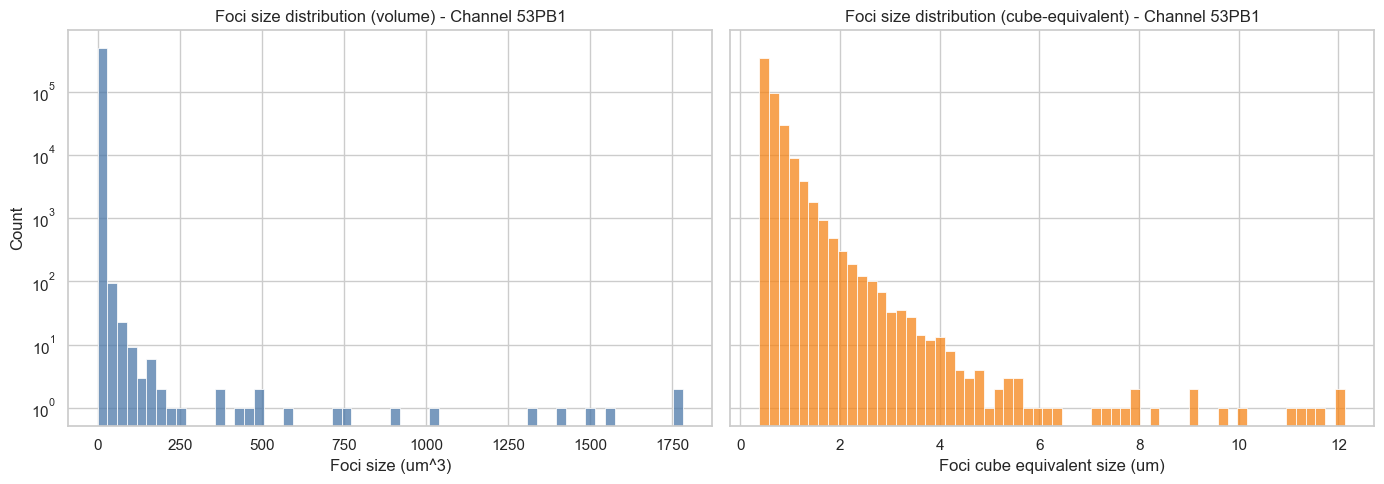

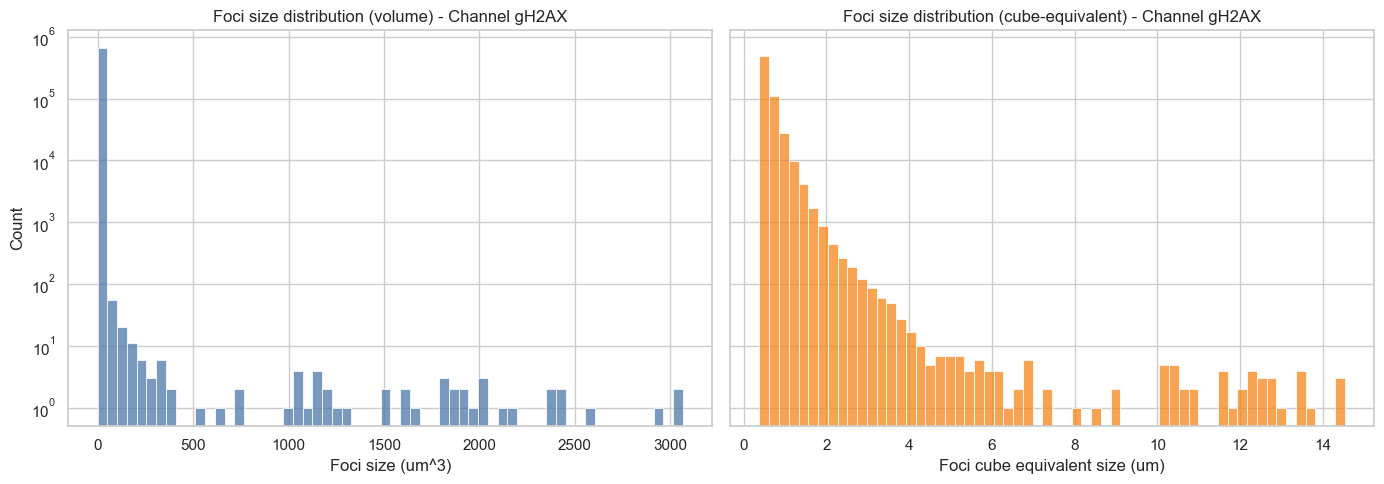

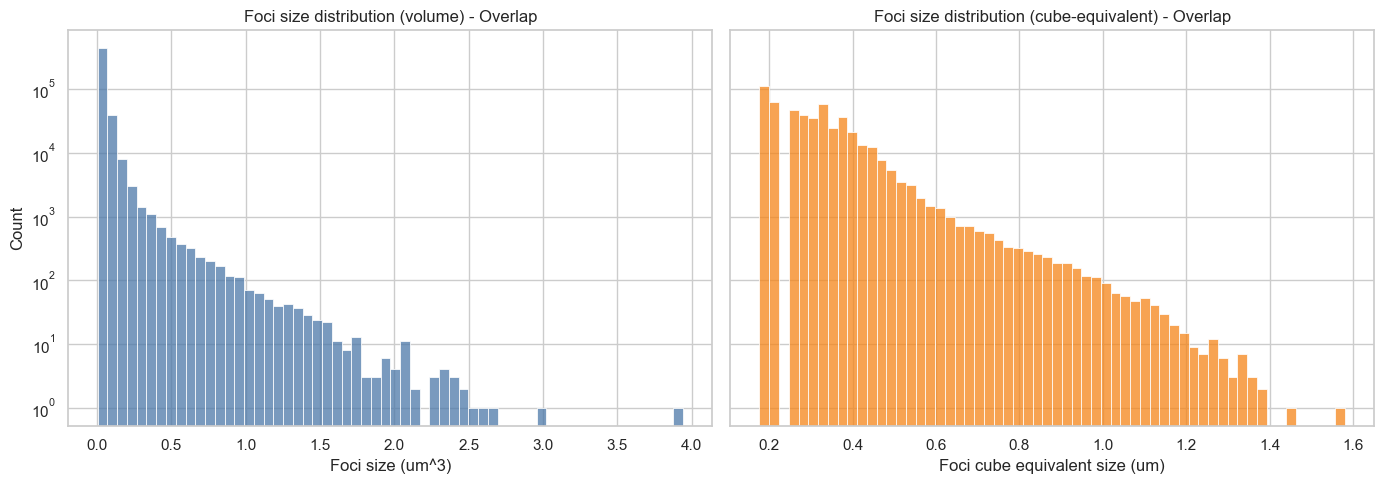

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_volume_vs_cube_distribution(df, title_suffix="", bins=60):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    # Left: foci volume (um^3)
    sns.histplot(
        data=df,
        x="vol",
        bins=bins,
        kde=False,
        ax=axes[0],
        color="#4C78A8"
    )
    axes[0].set_title(f"Foci size distribution (volume){title_suffix}")
    axes[0].set_xlabel("Foci size (um^3)")
    axes[0].set_ylabel("Count")
    axes[0].set_yscale("log")

    # Right: cube-equivalent size (um)
    sns.histplot(
        data=df,
        x="x",
        bins=bins,
        kde=False,
        ax=axes[1],
        color="#F58518"
    )
    axes[1].set_title(f"Foci size distribution (cube-equivalent){title_suffix}")
    axes[1].set_xlabel("Foci cube equivalent size (um)")
    axes[1].set_ylabel("Count")
    axes[1].set_yscale("log")

    plt.tight_layout()
    plt.show()

plot_volume_vs_cube_distribution(ch1_df, " - Channel 53PB1")
plot_volume_vs_cube_distribution(ch2_df, " - Channel gH2AX")
plot_volume_vs_cube_distribution(overlap_df, " - Overlap")

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def add_experiment_metadata(input_df):
    df = input_df.copy()

    # Normalize text a bit (comma decimals, extra spaces)
    s = (
        df["image_info"]
        .str.replace(",", ".", regex=False)
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )

    first_chunk = s.str.extract(r"^([^/]+)", expand=False)
    df["cell_line"] = first_chunk.str.extract(r"^([A-Za-z0-9-]+)", expand=False)

    # Dose
    dose_s = s.apply(lambda x: x.split("/")[1])
    dose_s = dose_s.apply(lambda x: x.replace("IR_", "IR ").replace("IR ", "").split("_")[0])

    dose_s = (
        dose_s.astype(str)
              .str.replace(",", ".", regex=False)
              .str.replace("Gy", "", regex=False)
              .str.strip()
    )

    df["dose_gy"] = pd.to_numeric(dose_s, errors="coerce")
    df["dose"] = df["dose_gy"].map(lambda v: f"{v:g} Gy" if pd.notna(v) else np.nan)

    # Time
    s_time = s.apply(lambda x: x.split("/")[0].replace("_", " ").split(" ")[1])
    s_time = (
        s_time.astype(str)
              .str.strip()
              .str.lower()
              .replace({"30": "30min", "30min": "30min", "8h": "8h"})
    )

    df["time_raw"] = s_time
    df["timepoint"] = df["time_raw"].map({
        "30min": "Early (30 min)",
        "8h": "Late (8h)"
    })

    return df

ch1_df = add_experiment_metadata(ch1_df)
ch2_df = add_experiment_metadata(ch2_df)
overlap_df = add_experiment_metadata(overlap_df)

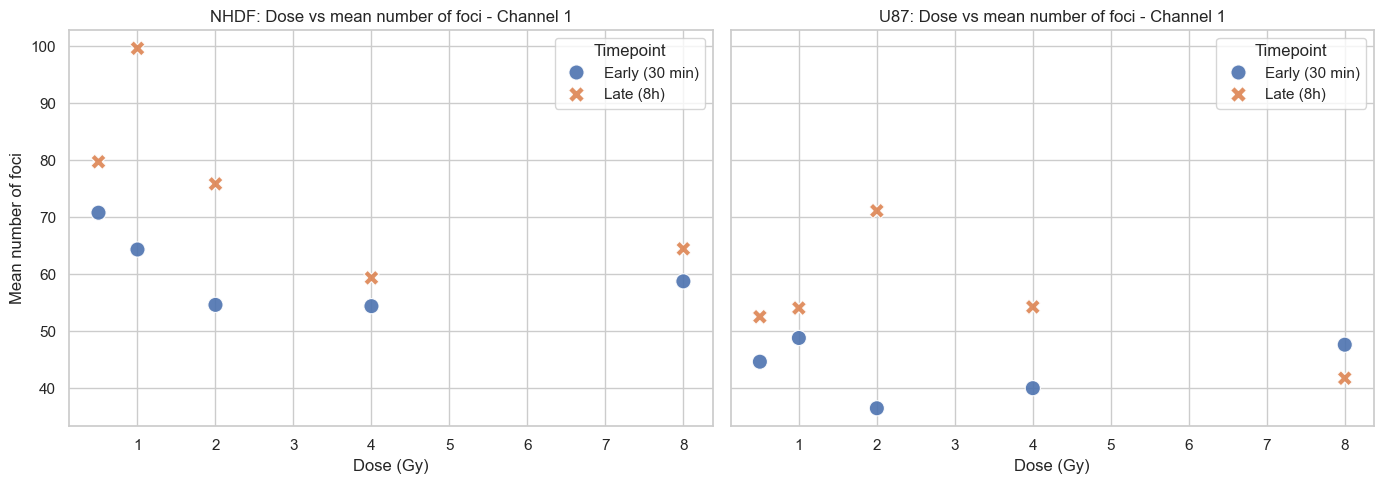

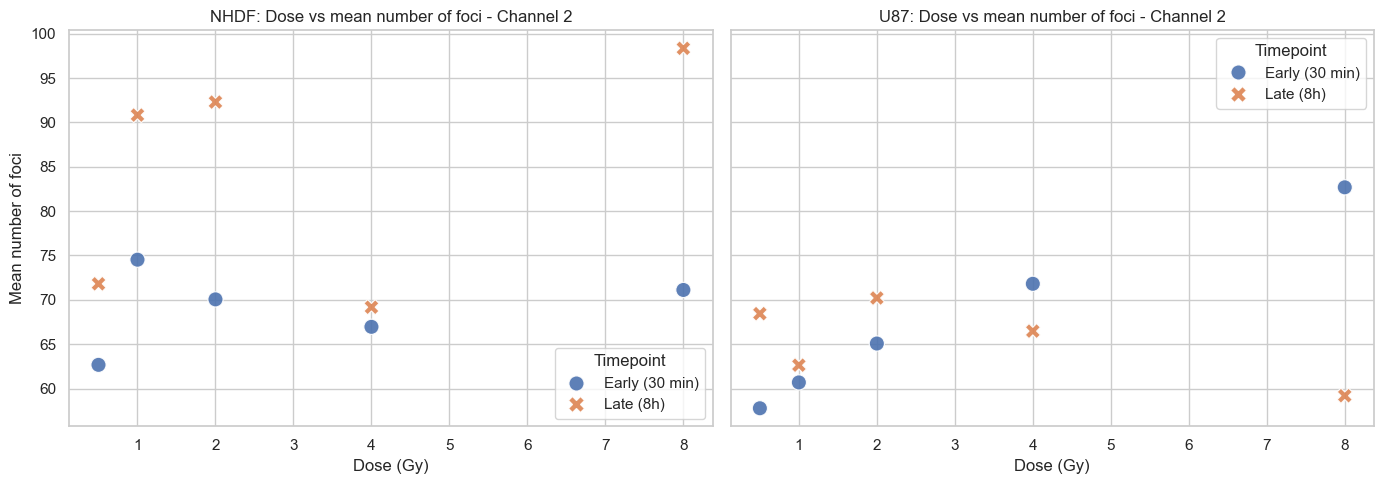

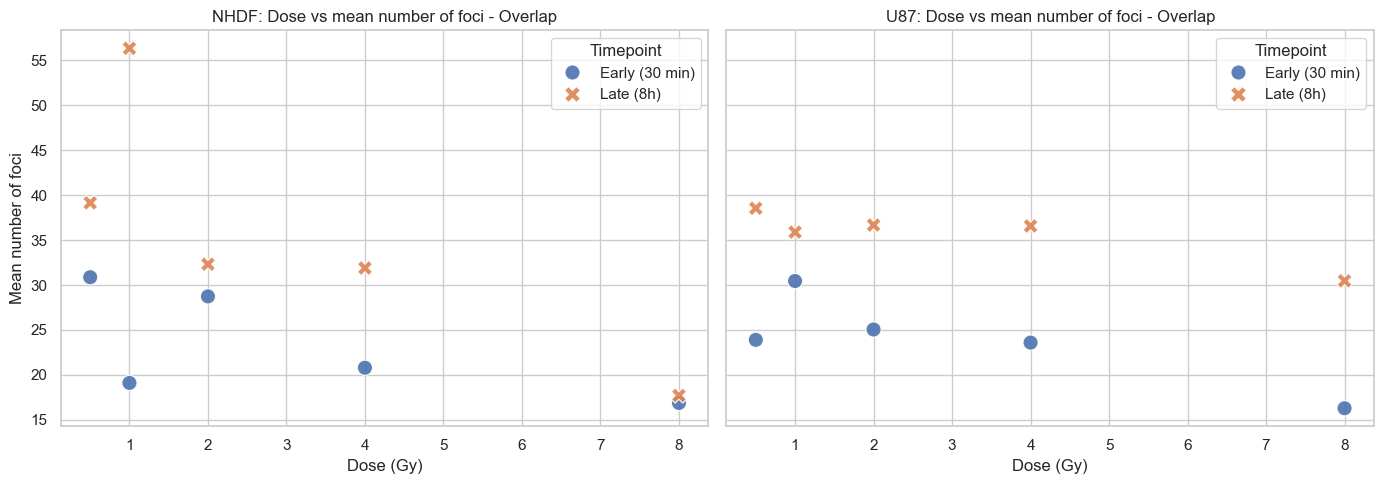

In [65]:
def plot_dose_vs_n_foci_by_cell_line(input_df, title_suffix=""):
    df_grouped = (
        input_df.groupby("image_info", as_index=False)
        .agg(
            cell_line=("cell_line", "first"),
            dose_gy=("dose_gy", "first"),
            timepoint=("timepoint", "first"),
            n_foci=("foci_size", "mean"),
        )
        .groupby(["dose_gy", "cell_line", "timepoint"], as_index=False)
        .agg(n_foci=("n_foci", "mean"))
    )


    cell_lines = sorted(df_grouped["cell_line"].dropna().unique())
    fig, axes = plt.subplots(1, len(cell_lines), figsize=(7 * len(cell_lines), 5), sharey=True)

    if len(cell_lines) == 1:
        axes = [axes]

    for ax, cl in zip(axes, cell_lines):
        dsub = df_grouped[df_grouped["cell_line"] == cl]
        sns.scatterplot(
            data=dsub,
            x="dose_gy",
            y="n_foci",
            hue="timepoint",
            style="timepoint",
            s=120,
            alpha=0.9,
            ax=ax,
        )
        ax.set_title(f"{cl}: Dose vs mean number of foci{title_suffix}")
        ax.set_xlabel("Dose (Gy)")
        ax.set_ylabel("Mean number of foci")
        ax.legend(title="Timepoint")

    plt.tight_layout()
    plt.show()

    return df_grouped


df_grouped_ch1 = plot_dose_vs_n_foci_by_cell_line(ch1_df, " - Channel 1")
df_grouped_ch2 = plot_dose_vs_n_foci_by_cell_line(ch2_df, " - Channel 2")
df_grouped_overlap = plot_dose_vs_n_foci_by_cell_line(overlap_df, " - Overlap")

# keep backward compatibility
df_grouped = df_grouped_overlap.copy()